# Projet Stratégies d'Investissement Alternatives et Quantitatives
## Jérémy Bellina, Joël Zhu

# Set up all packages and information

In [1]:
# import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# load the crypto prices csv data
crypto_prices = pd.read_csv("crypto_prices.csv", parse_dates=[0])
crypto_prices.set_index('date', inplace=True)

# load the CRIX index csv data
crix_prices = pd.read_csv("vcrix.csv", parse_dates=[0])
crix_prices.set_index('date', inplace=True)
crix_prices = crix_prices.drop(["Unnamed: 0", "n"], axis=1)
crix_prices = crix_prices.loc["2018-04-01":]

# load the Fama & French momentum factor csv data
FFMomentum = pd.read_csv("F-F_Momentum_Factor_daily.CSV", parse_dates=[0])
FFMomentum = FFMomentum.rename(columns={'Unnamed: 0': 'date'})
FFMomentum.set_index('date', inplace=True)
FFMomentum = FFMomentum.loc["2018-04-01":]

# load the Fama & French research data factor csv data
FFResearch = pd.read_csv("F-F_Research_Data_Factors_daily.CSV", parse_dates=[0])
FFResearch = FFResearch.rename(columns={'Unnamed: 0': 'date'})
FFResearch.set_index('date', inplace=True)
FFResearch = FFResearch.loc["2018-04-01":]

In [3]:
# create rebalancing dates array
rebalancing_dates = pd.date_range(start = "2018-04-01", end = "2020-05-01", freq = pd.DateOffset(months=1, day = 1))
formatted_dates = pd.date_range(start = "2018-04-01", end = "2020-05-26")

In [4]:
# horizon
horizon = 15
#initial value
initial_value = 100

# Helper functions

In [5]:
def sort_returns(current_date, data):
    date = str(current_date.date())
    # We sort those returns
    sorted_returns = data.loc[date].sort_values(ascending=False)
    
    return sorted_returns

In [6]:
def compute_value(date, portfolio, crypto_prices):
    value = 0
    for item in portfolio:
        value += item[1] * crypto_prices.loc[date, item[0]]
    return value

In [7]:
def update_portfolio(amount, data, date, crypto_names):
    portfolio = []
    for name in crypto_names:
        portfolio.append((name, amount / data.loc[date, name]))
    return portfolio

# Portfolio backtests

Creates portfolio long on all crypto currencies **equally weighted**

In [8]:
def get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, data, portfolio_index):
    values = [initial_value]
    returns = data.pct_change(periods=horizon)
    portfolio = []
    for date in formatted_dates:
        if str(date) != "2018-04-01 00:00:00":
            values.append(compute_value(date, portfolio, data)) # update values
        if date in rebalancing_dates:
            sorted_returns = sort_returns(date, returns) # sort returns for the rebalancing date
            crypto_names = sorted_returns.iloc[(10 * (portfolio_index - 1)):(10 * portfolio_index)].index # extract crypto
            portfolio = update_portfolio(values[-1] / 10, data, date, crypto_names) # update composition

    return values

Creates a portfolio **long on best returns** crypto currencies and **short on lowest returns** ones

In [9]:
 def long_short_strategy(ptf_values1, ptf_values5):
    values = []
    for value1, value5 in zip(ptf_values1, ptf_values5):
        values.append(value1 - value5)
    return values

# Plot of portfolios values 

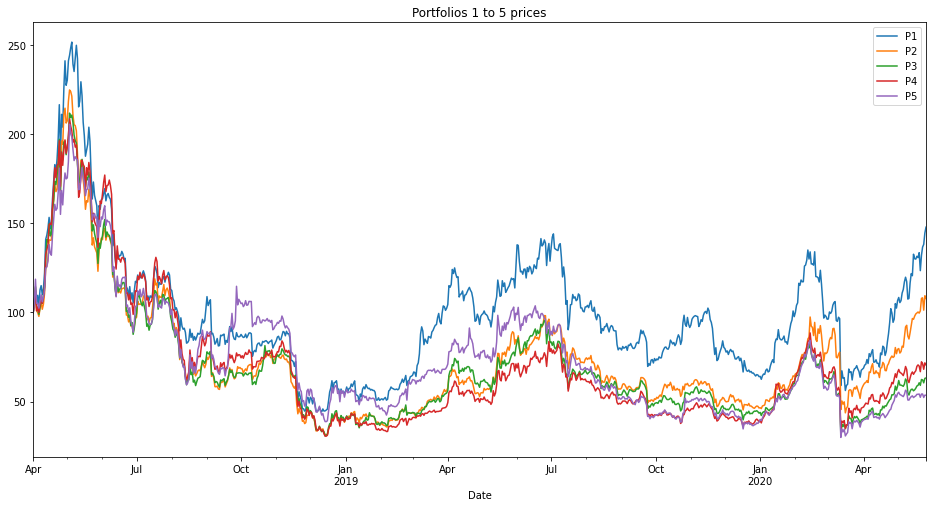

In [10]:
ptf_values1 = get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 1)
ptf_values2 = get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 2)
ptf_values3 = get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 3)
ptf_values4 = get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 4)
ptf_values5 = get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 5)

all_ptf_values = pd.DataFrame(data = {'Date': formatted_dates, 'P1': ptf_values1, 'P2': ptf_values2, 'P3': ptf_values3, 'P4': ptf_values4, 'P5': ptf_values5})
all_ptf_values.set_index('Date', inplace=True)

all_ptf_values.plot(figsize=(16,8), title="Portfolios 1 to 5 prices")

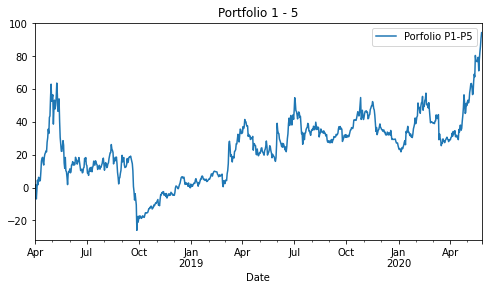

In [11]:
ptf_values1 = get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 1)
ptf_values5 = get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 5)
final_values = long_short_strategy(ptf_values1, ptf_values5)

ptf_values = pd.DataFrame(data = {'Date': formatted_dates, 'Porfolio P1-P5': final_values})
ptf_values.set_index('Date', inplace=True)
ptf_values.plot(figsize=(8,4), title="Portfolio 1 - 5")

# Statistical description

## Initialization

In [31]:
# We get all the values of the 5 portfolios
ptf_values1 = get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 1)
ptf_values2 = get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 2)
ptf_values3 = get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 3)
ptf_values4 = get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 4)
ptf_values5 = get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 5)

all_ptf_values = pd.DataFrame(data = {'Date': formatted_dates, 'P1': ptf_values1, 'P2': ptf_values2, 'P3': ptf_values3, 'P4': ptf_values4, 'P5': ptf_values5})
all_ptf_values.set_index('Date', inplace=True)
all_ptf_daily_returns = all_ptf_values.pct_change()

## Mean

In [32]:
# We compute the mean for all portfolios returns
means = all_ptf_daily_returns.mean()

means

P1    0.001651
P2    0.001213
P3    0.000491
P4    0.000686
P5    0.000440
dtype: float64

## Standard deviation

In [33]:
# We compute the standard deviation for all portfolios returns
stddev =all_ptf_daily_returns.std()
stddev

P1    0.047095
P2    0.046147
P3    0.045343
P4    0.046768
P5    0.048832
dtype: float64

## Median

In [34]:
# We compute the median for all portfolios returns
median = all_ptf_daily_returns.median()
median

P1    0.003487
P2    0.002854
P3    0.002478
P4    0.003057
P5    0.003053
dtype: float64

## Minimum

In [35]:
# We get the minimum for all portfolios returns
minimum = all_ptf_daily_returns.min()
minimum

P1   -0.388953
P2   -0.414802
P3   -0.398284
P4   -0.385747
P5   -0.426499
dtype: float64

## Maximum

In [36]:
# We get the max for all portfolios returns
maximum = all_ptf_daily_returns.max()
maximum

P1    0.153043
P2    0.186089
P3    0.168602
P4    0.252157
P5    0.210899
dtype: float64

# Performance measures

## Initialization

In [ ]:
ptf_values1 = get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 1)
ptf_values2 = get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 2)
ptf_values3 = get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 3)
ptf_values4 = get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 4)
ptf_values5 = get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 5)

all_ptf_values = pd.DataFrame(data = {'date': formatted_dates, 'P1': ptf_values1, 'P2': ptf_values2, 'P3': ptf_values3, 'P4': ptf_values4, 'P5': ptf_values5})
all_ptf_values.set_index('date', inplace=True)

all_ptf_pct_change = all_ptf_values.pct_change()
all_ptf_rets = 1+ all_ptf_pct_change
all_ptf_rets.iloc[0,:] = 1
all_ptf_rets = all_ptf_rets.cumprod()

## Sharpe

In [ ]:
P1_num = (all_ptf_rets["P1"] - FFResearch['RF']).dropna()
P1_denom = np.std(all_ptf_rets["P1"])
print(np.mean(P1_num)/P1_denom)

P2_num = (all_ptf_rets["P2"] - FFResearch['RF']).dropna()
P2_denom = np.std(all_ptf_rets["P2"])
print(np.mean(P2_num)/P2_denom)

P3_num = (all_ptf_rets["P3"] - FFResearch['RF']).dropna()
P3_denom = np.std(all_ptf_rets["P3"])
print(np.mean(P3_num)/P3_denom)

P4_num = (all_ptf_rets["P4"] - FFResearch['RF']).dropna()
P4_denom = np.std(all_ptf_rets["P4"])
print(np.mean(P4_num)/P4_denom)

P5_num = (all_ptf_rets["P5"] - FFResearch['RF']).dropna()
P5_denom = np.std(all_ptf_rets["P5"])
print(np.mean(P5_num)/P5_denom)

## Treynor

In [ ]:
R_Rf = (all_ptf_pct_change["P1"] - FFResearch['RF']).dropna()
crix_rets = crix_prices.pct_change()

Rm_Rf = (crix_rets["vcrix"] - FFResearch['RF']).dropna()

print(R_Rf)
print(Rm_Rf)

intercept = sm.add_constant(Rm_Rf)
reg = sm.OLS(R_Rf, intercept).fit()

print(reg.summary())

## Jensen